## Presentation

A notebook to process BCDI data using cdiutils package and PyNX phase retrieval

In [1]:
import os
import hdf5plugin # if data are too large
from xrayutilities import en2lam

import cdiutils

The bcdi package is not installed. bcdi backend won't be available


## Processing parameters

In [19]:
metadata = {
  "beamline_setup": "ID01SPEC", # Required
  "scan": 184, # Required
  "sample_name": "Pt", # Required for ID01BLISS, P10 and SIXS2022 setups
  "experiment_file_path": "spec/ALIGN_2020_11_24_084524.spec", # Required for ID01SPEC, ID01BLISS setups
  "experiment_data_dir_path": "", # Required for P10 and SIXS2022 setups
  "detector_data_path": "detector/", # Required for ID01SPEC setup
  "edf_file_template": "data_mpx4_%05d.edf.gz", # Required for ID01SPEC setup
  "detector_name": "mpx4inr", # Required
  "flatfield_path": None,
  "alien_mask": None,
  "dump_dir": "",
  "reconstruction_file": "mode.h5"
}
# Required. You choose: either you specify it in the metadata, or you
# want the dump_dir to be dependent on the 'sample_name' and 'scan' or
# other things. 
metadata["dump_dir"] = (
    os.getcwd() + f'/results/{metadata["sample_name"]}/S{metadata["scan"]}/'
)

preprocessing_output_shape = [70, 150, 150] # Required, 2 or 3 values. If 2, will take the whole RC 
energy = 12996 # Required, in eV
hkl = [0, 0, 2] # Required

# Required, must be a list of "com", "max" or tuple of int that corresponds
# to the position you want to crop the data at. It can be 2D. And you can
# mix it with binning_along_axis0. 
det_reference_voxel_method = ["max", "com", "com"]  # Ex: [(70, 200, 200), "com", "com"]
binning_along_axis0 = None  # Whether or not you want to bin in the RC direction
light_loading = False  # Load only the roi defined by the det_reference_voxel and preprocessing_output_shape

# Required
det_calib_parameters = {
  "cch1": 417.07983599290066,
  "cch2": 29.598791889093572,
  "detrot": -1.2384615384615385,
  "distance": 0.8675438689835612,
  "outerangle_offset": 0.0,
  "pwidth1": 5.5e-05,
  "pwidth2": 5.5e-05,
  "tilt": 2.204308447695206,
  "tiltazimuth": 240.6674276261259
}

voxel_size = None
apodize = "blackman"
flip = False
isosurface = None

# Display parameters
show = True
verbose = True
debug = False

# PyNX parameters

# You can leave as it is
data = (
    metadata["dump_dir"]
    + "/pynx_phasing/"
    + f"S{metadata['scan']}_pynx_input_data.npz"
)

mask = (
    metadata["dump_dir"]
    + "/pynx_phasing/"
    + f"S{metadata['scan']}_pynx_input_mask.npz"
)

data2cxi = True

# support_size is the radius or half-size for the initial support. 
# Either one value (will be attributed to all dimensions), or one value 
# for each dimension. To be used in combination with support (which must 
# be different to "auto"). If support is "auto", leave support_size to
# None.
support = "auto"
support_size = None  

support_threshold = "0.15, 0.40"
support_threshold_method = "rms"
support_only_shrink = False
support_update_period = 20
support_smooth_width_begin = 2
support_smooth_width_end = 1
support_post_expand = "-1,1"
psf = "pseudo-voigt,0.5,0.1,10"

nb_raar = 500
nb_hio = 300
nb_er = 200
nb_ml = 0
nb_run = 15
nb_run_keep = 10

zero_mask = False
crop_output = 0
positivity = False
beta = 0.9
detwin = False

rebin = "1,1,1"
detector_distance = det_calib_parameters["distance"]
pixel_size_detector = det_calib_parameters["pwidth1"]
wavelength = float(en2lam(energy) * 1e-10)  # wavelength in m

verbose = 100
output_format = "cxi"
live_plot = False
save_plot = True
mpi = "run"


# Load the parameters and parse them into the BcdiPipeline class instance 
parameters = cdiutils.process.get_parameters_from_notebook_variables(
    dir(), globals()
)
bcdi_pipeline = cdiutils.process.BcdiPipeline(parameters=parameters)

### Preprocess the data: crop and center the data and compute orthogonalization parameters


***********************************************************************************
*                  [INFO] Proceeding to preprocessing (Pt, S184)                  *
***********************************************************************************


[INFO] Dump directory already exists, results will be saved in:
/mnt/multipath-shares/scisoft/clatlan/misc/Nat_Mat_paper_data/results/Pt/S184/.


[SHAPE & CROPPING] The preprocessing output shape is: (70, 150, 150) and will be
used for ROI dimensions.
[SHAPE & CROPPING] Method(s) employed for the reference voxel determination are
['max', 'com', 'com'].
Chain centering:
	- max: (45, 389, 160), value: 13473
	- com: (46, 387, 160), value: 12929
	- com: (46, 387, 160), value: 12929

[SHAPE & CROPPING] The reference voxel was found at (46, 387, 160) in the
uncropped data frame
The processing_out_put_shape being (70, 150, 150), the roi
used to crop the data is [11, 81, 312, 462, 85, 235].

[INFO] Oversampling ratios calculated from diffraction pattern are: axis0: 2.9,
axis1: 8.3, axis2: 5.0. If low-strain crystal, you can set PyNX 'rebin'
parameter to (1.0, 4.0, 2.0)

Summary table:
(max and com in the cropped frame are different to max and com in the uncropped
detector frame.)
╒═══════════╤══════════════════════╤═════════════════════╤════════════════╤═════════════════╕
│ voxel     │ uncroped det. pos.   │ cropped det. pos.   │   dspa

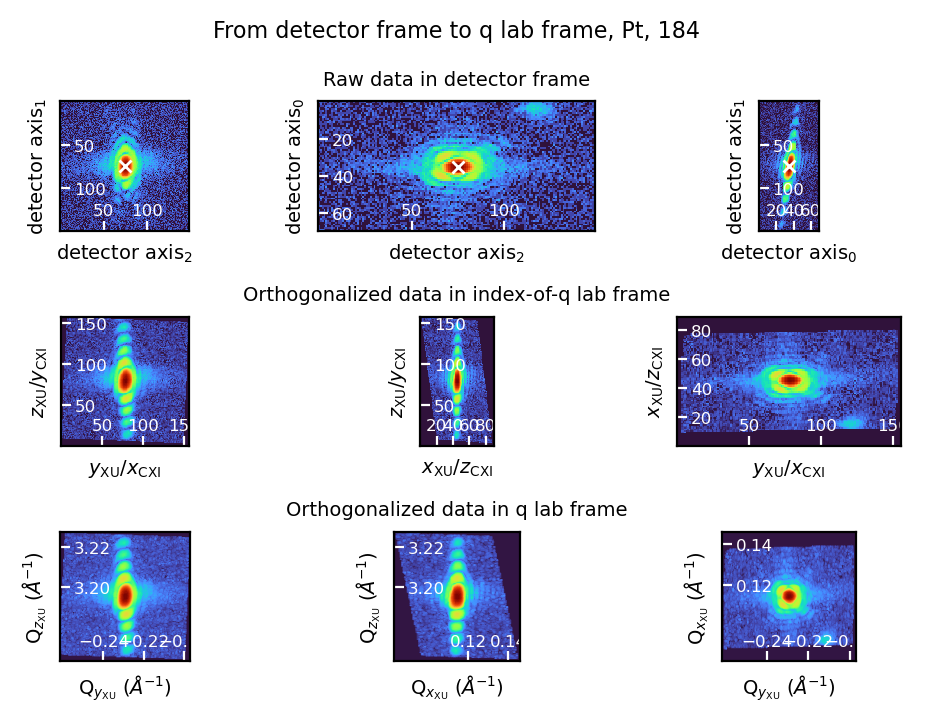

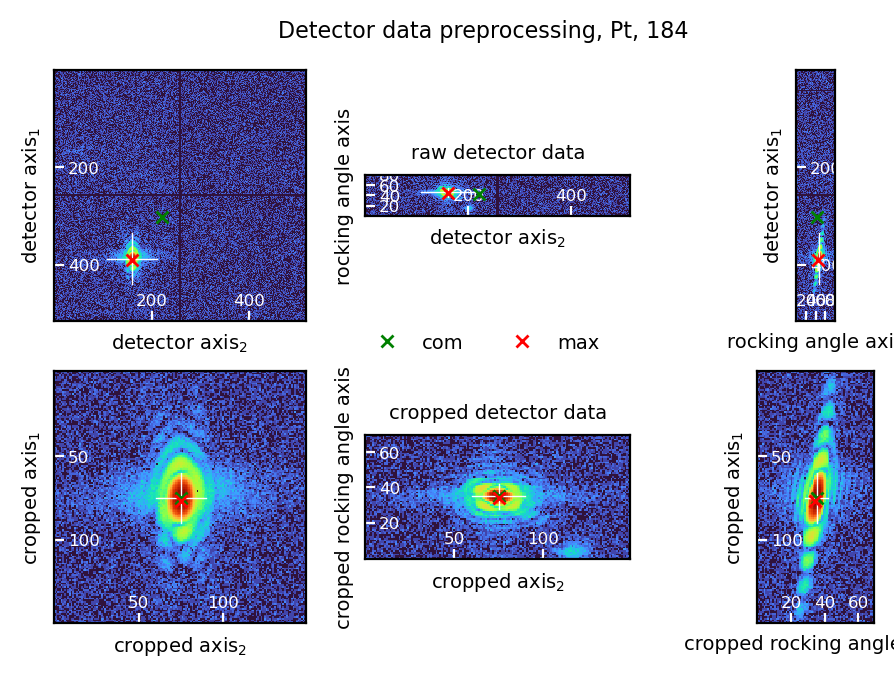

In [20]:
bcdi_pipeline.preprocess()

### Run PyNX phase retrieval using ESRF's p9 GPUs or another machine

In [21]:
# Here you can update PyNX parameters before running the phasing

# bcdi_pipeline.params["pynx"].update(
#     {
#         "rebin": "1,1,1",
#         "support_update_period": 20,
#         "support_threshold": "0.15, 0.40"
#     }
# )

user = os.environ["USER"]
key_file_path = os.environ["HOME"] + "/.ssh/id_rsa"
number_of_nodes = 2

print(
    f"Will use the user name '{user}' "
    f"and the private key file path:\n'{key_file_path}'"
)

bcdi_pipeline.phase_retrieval(
    machine="slurm-nice-devel",
    # machine="lid01pwr9",
    user=user,
    number_of_nodes=number_of_nodes,
    key_file_path=key_file_path,
    clear_former_results=True
)

Will use the user name 'atlan' and the private key file path:
'/users/atlan/.ssh/id_rsa'

***********************************************************************************
*              [INFO] Proceeding to PyNX phase retrieval (Pt, S184)               *
***********************************************************************************

[INFO] Removing former results.

[INFO] Connected to slurm-nice-devel
Pynx slurm file template not provided, will take the default: /mnt/multipath-shares/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/process/pynx-id01cdi_template.slurm
Submitted batch job 14973381

[INFO] process status: PENDING
[INFO] process status: PENDING
[INFO] process status: PENDING
[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING
#  CDI Run: 1/15  support_threshold = 0.295
#  CDI Run: 5/15  support_threshold = 0.344
#  CDI Run: 9/15  support_threshold = 0.268
#  CDI Run: 13/15  support_thre

### Analyse the phasing results

[INFO] Computing metrics...
[INFO] the sorted list of runs using sorting_criterion 'mean_to_max' is:
['05', '04', '15', '03', '08', '11', '13', '01', '07', '09']
[INFO] Plotting phasing results...


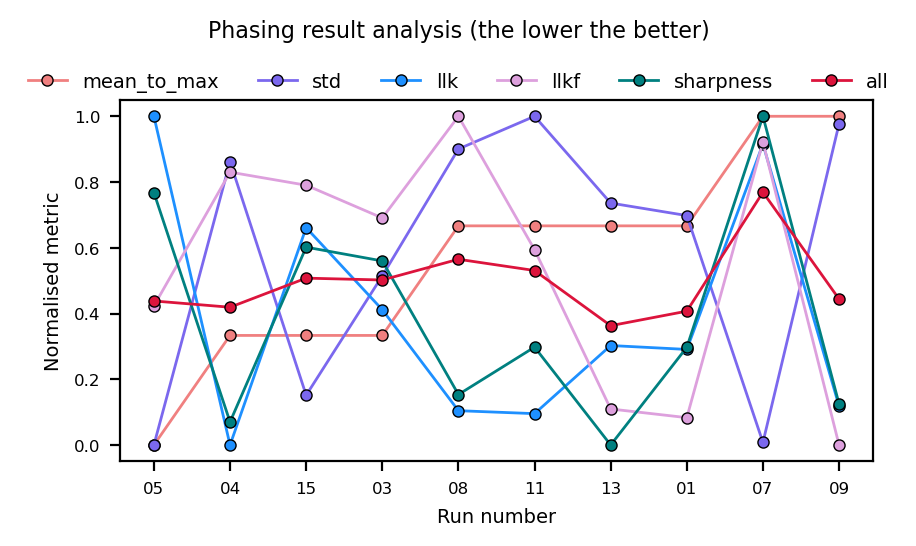

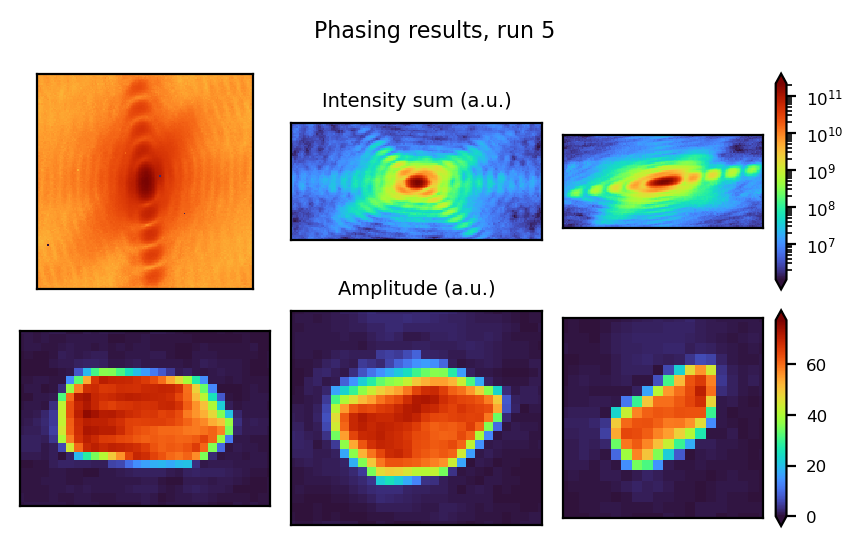

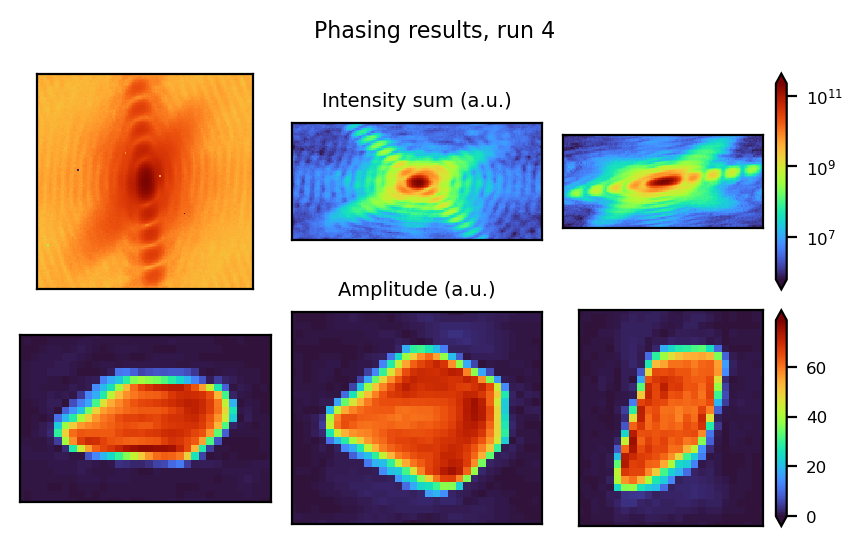

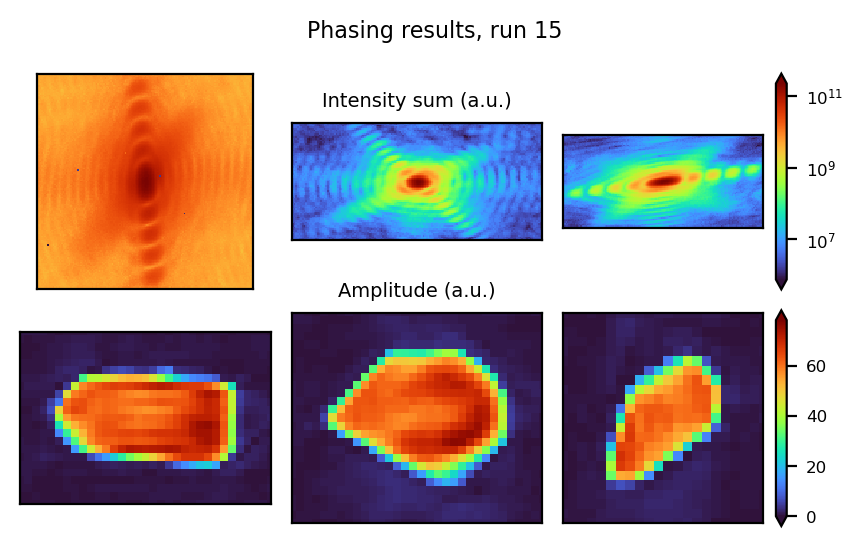

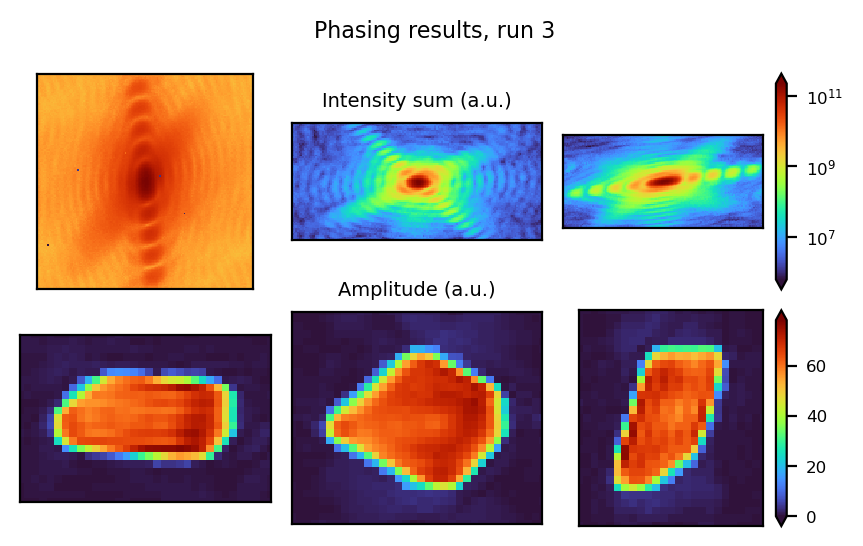

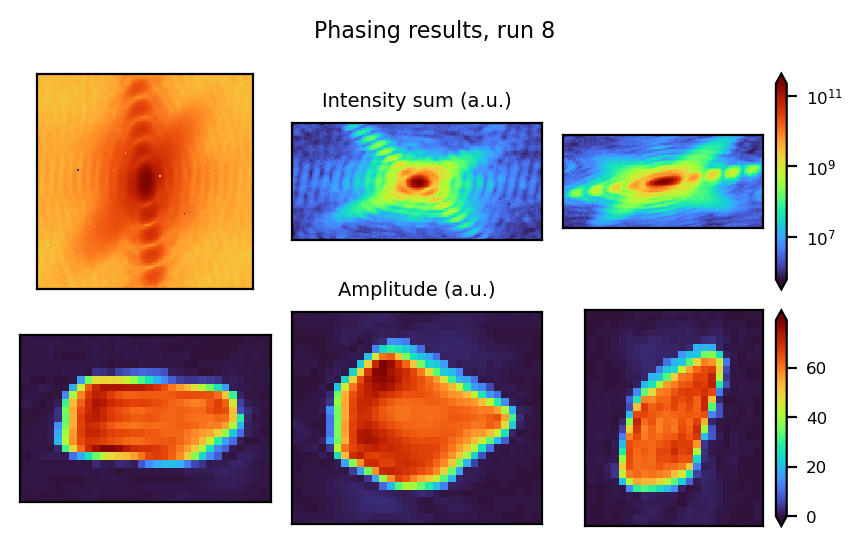

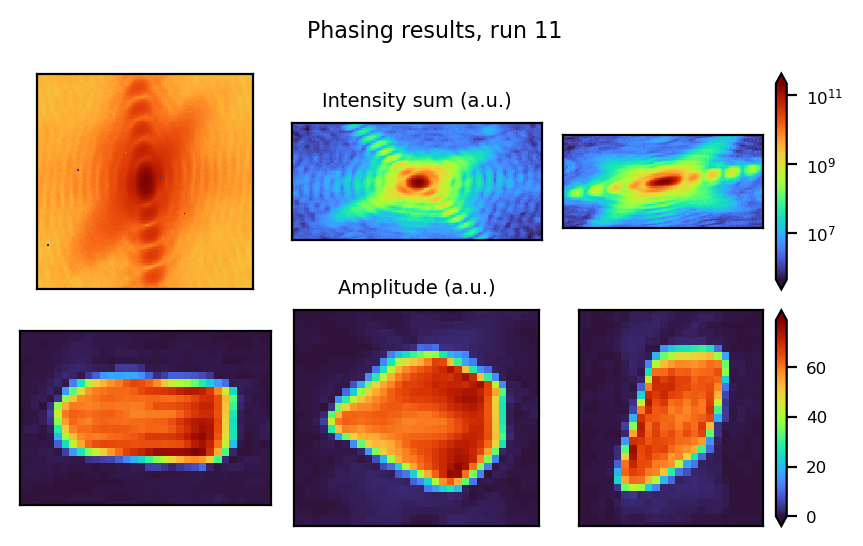

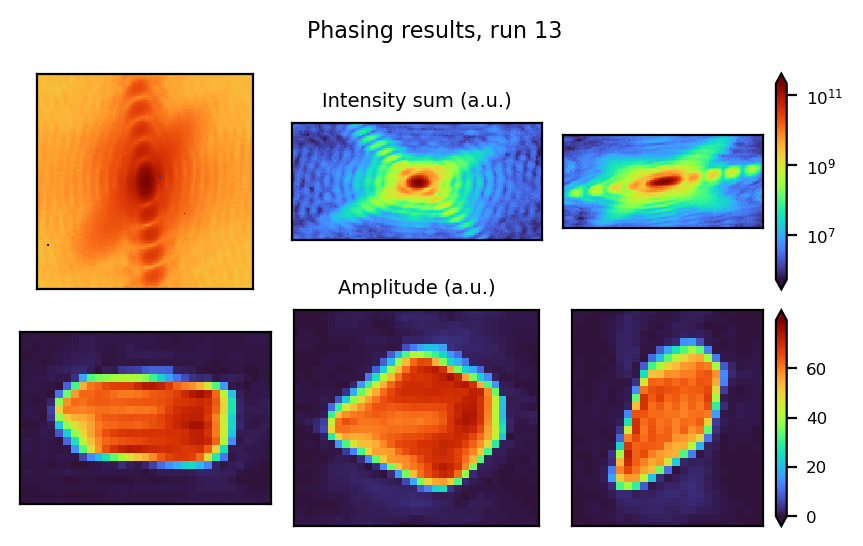

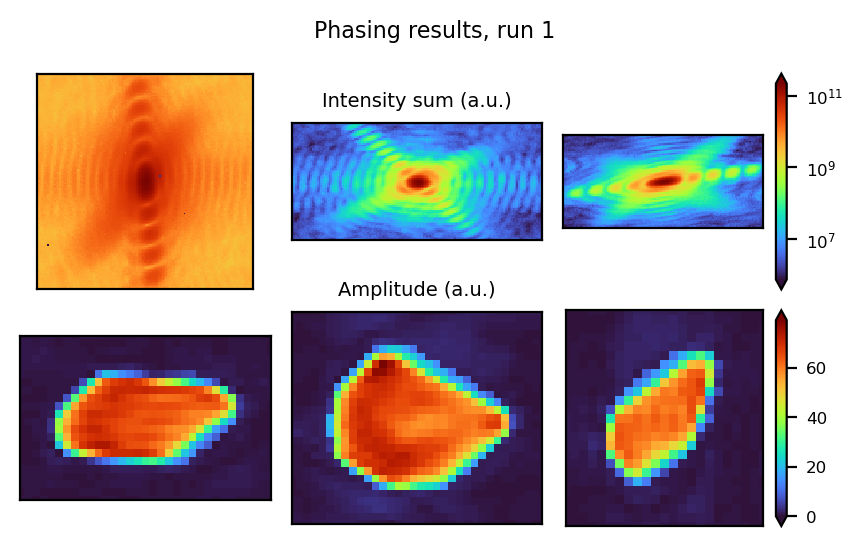

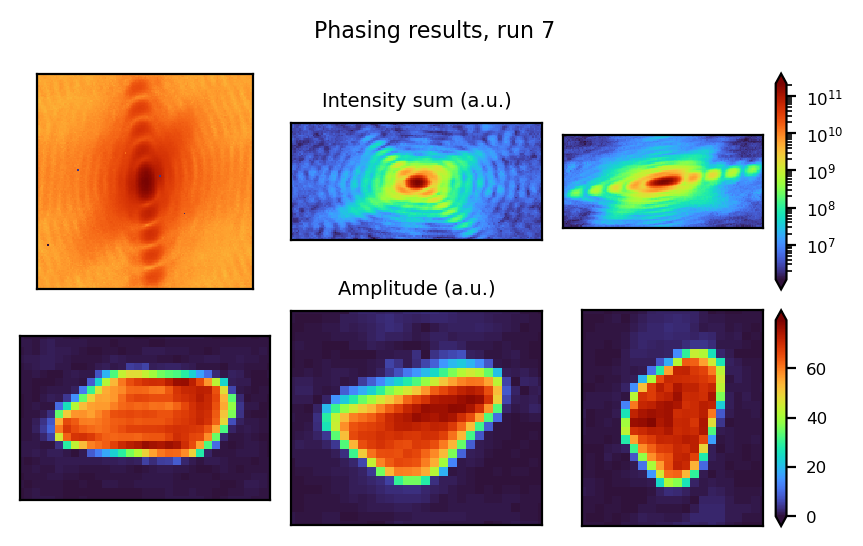

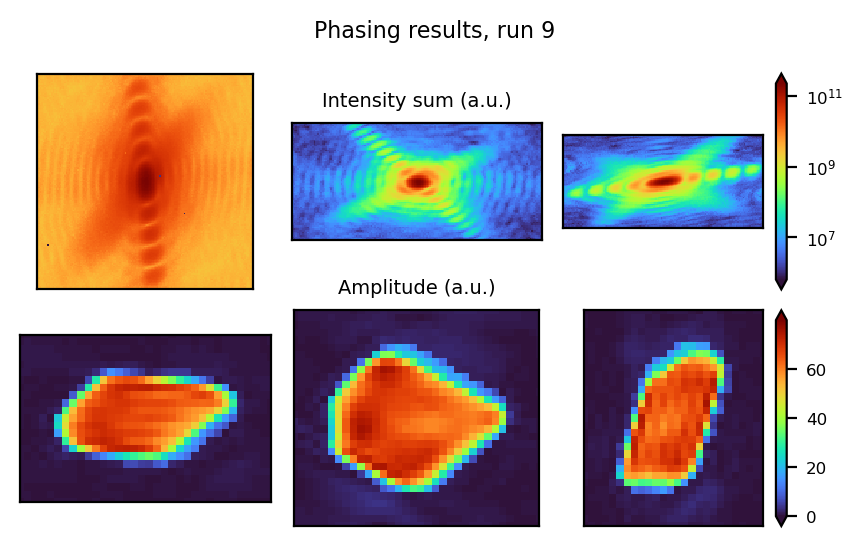

In [22]:
bcdi_pipeline.analyse_phasing_results(
    sorting_criterion="mean_to_max",
    # plot_phasing_results=False,  # Defaults to True
    # plot_phase=True,  # Defaults to False
)

### Select the best reconstructions decompose them into one mode

In [23]:
# Chose the number of best candidates you want to keep.
number_of_best_candidates: int = 5

# You can either select the best candidates by specifying the
# reconstruction number or just provide the number of runs you
# want to consider. The "best" runs are selected according to the
# sorting_criterion above. 
bcdi_pipeline.select_best_candidates(
    # best_runs=[10]
    nb_of_best_sorted_runs=number_of_best_candidates
)

bcdi_pipeline.mode_decomposition()

[INFO] Best candidates selected:
['05', '04', '15', '03', '08']
[STDOUT FROM SUBPROCESS]
 Importing data files
Loading 5 files in // [4 proc]
    Loading: candidate_1-5_S184_run_05.cxi
    Loading: candidate_2-5_S184_run_04.cxi
    Loading: candidate_3-5_S184_run_15.cxi
    Loading: candidate_4-5_S184_run_03.cxi
    Loading: candidate_5-5_S184_run_08.cxi
Calculating modes from the imported objects
Matching arrays against the first one [candidate_1-5_S184_run_05.cxi] - this may take a while
Matching 5 arrays in // [4 proc]
    R_match(1) = 17.151%
    R_match(2) = 14.564%
    R_match(3) = 21.038%
    R_match(4) = 19.682%
Elapsed time:    1.1s
Analysing modes
First mode represents 98.123%
Saving modes analysis to: mode.h5



### Finally postprocess the data: orthogonalize, compute phase, dispacement, strain, dspacing...

In [27]:
# Here you can update a few post-processing parameters instead of going
# back up to the top of the notebook.

# This is whether you want to play with support/surface determination
# By default the tradional method "Isosurface" is used, so you do not need
# to update the following parameters
# bcdi_pipeline.params["cdiutils"].update(
#     {
#         "method_det_support": "Isosurface",  # "Isosurface" or "Amplitude_variation"
#         "order_of_derivative": "Gradient",  # "Gradient" or "Laplacian"
#         "raw_process" : True,
#     }
# )

# However, you can play with these
bcdi_pipeline.params["cdiutils"].update(
    {
        "isosurface": None,
        "voxel_size": 10,
        "flip": False,
        "apodize": "blackman",
        "handle_defects": False
    }
)

bcdi_pipeline.postprocess()


***********************************************************************************
*                    [INFO] Running post-processing(Pt, S184)                     *
***********************************************************************************


[ERROR] An error occured in the 'postprocess' method... here is the traceback:



Traceback (most recent call last):
  File "/mnt/multipath-shares/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/process/pipeline.py", line 134, in wrapper
    func(*args, **kwargs)
  File "/mnt/multipath-shares/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/process/pipeline.py", line 833, in postprocess
    self.bcdi_processor.orthogonalize()
  File "/mnt/multipath-shares/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/process/processor.py", line 623, in orthogonalize
    raise FileNotFoundError(
FileNotFoundError: File was not found at: /mnt/multipath-shares/scisoft/clatlan/misc/Nat_Mat_paper_data/results/Pt/S184/pynx_phasing/mode.h5


FileNotFoundError: File was not found at: /mnt/multipath-shares/scisoft/clatlan/misc/Nat_Mat_paper_data/results/Pt/S184/pynx_phasing/mode.h5

### Facet analysis

In [26]:
# Here you can update a few post-processing parameters instead of going
# back up to the top of the notebook, ex:

bcdi_pipeline.params["cdiutils"].update(
    {
        "nb_facets": 13, # Expected number of facets of the particle
        "remove_edges": True,
        "nb_nghbs_min": 0,
        "authorized_index": ["max", 1],  # ['max',n],['absolute',a,b,c,...] or ['families',[h1,k1,l1],[h2,k2,l2],...]
        "index_to_display": [[0, 0, 1]],  # None for the top facet or [[h1,k1,l1],[h2,k2,l2],...]
        "display_f_e_c": "facet",  # 'facet', 'edge', 'corner', or 'all'
        "size": 10  # Size of the voxels in the visualization
    }
)

bcdi_pipeline.facet_analysis()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/multipath-shares/scisoft/clatlan/misc/Nat_Mat_paper_data/results/Pt/S184//cdiutils_S184_structural_properties.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)